# Importing necessary libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedShuffleSplit
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

# Loading dataset and Overview

In [ ]:
housing = pd.read_csv("housing.csv")

In [ ]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [ ]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [ ]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [ ]:
housing.shape

(20640, 10)

In [ ]:
housing.isnull().sum()

,0
longitude,0
latitude,0
housing_median_age,0
total_rooms,0
total_bedrooms,207
population,0
households,0
median_income,0
median_house_value,0
ocean_proximity,0


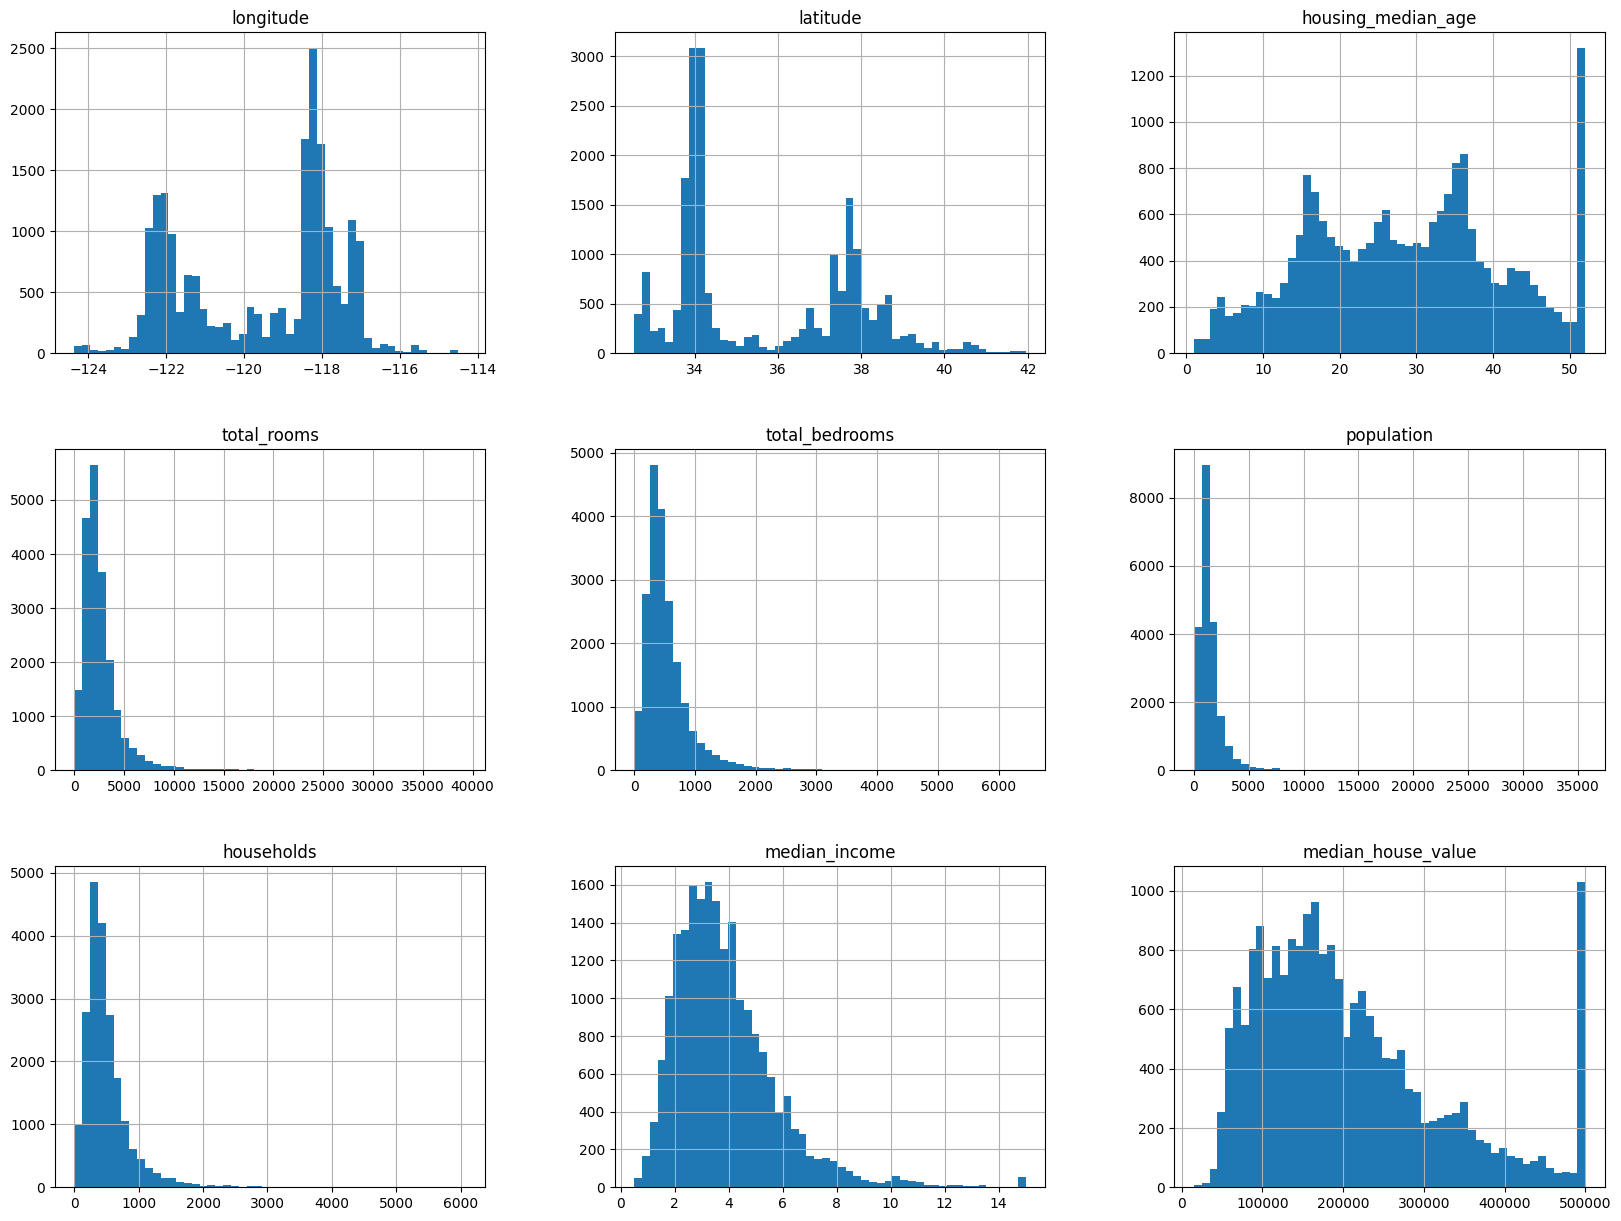

In [ ]:
# Visualize data distribution
housing.hist(bins=50, figsize=(20,15))
plt.show()

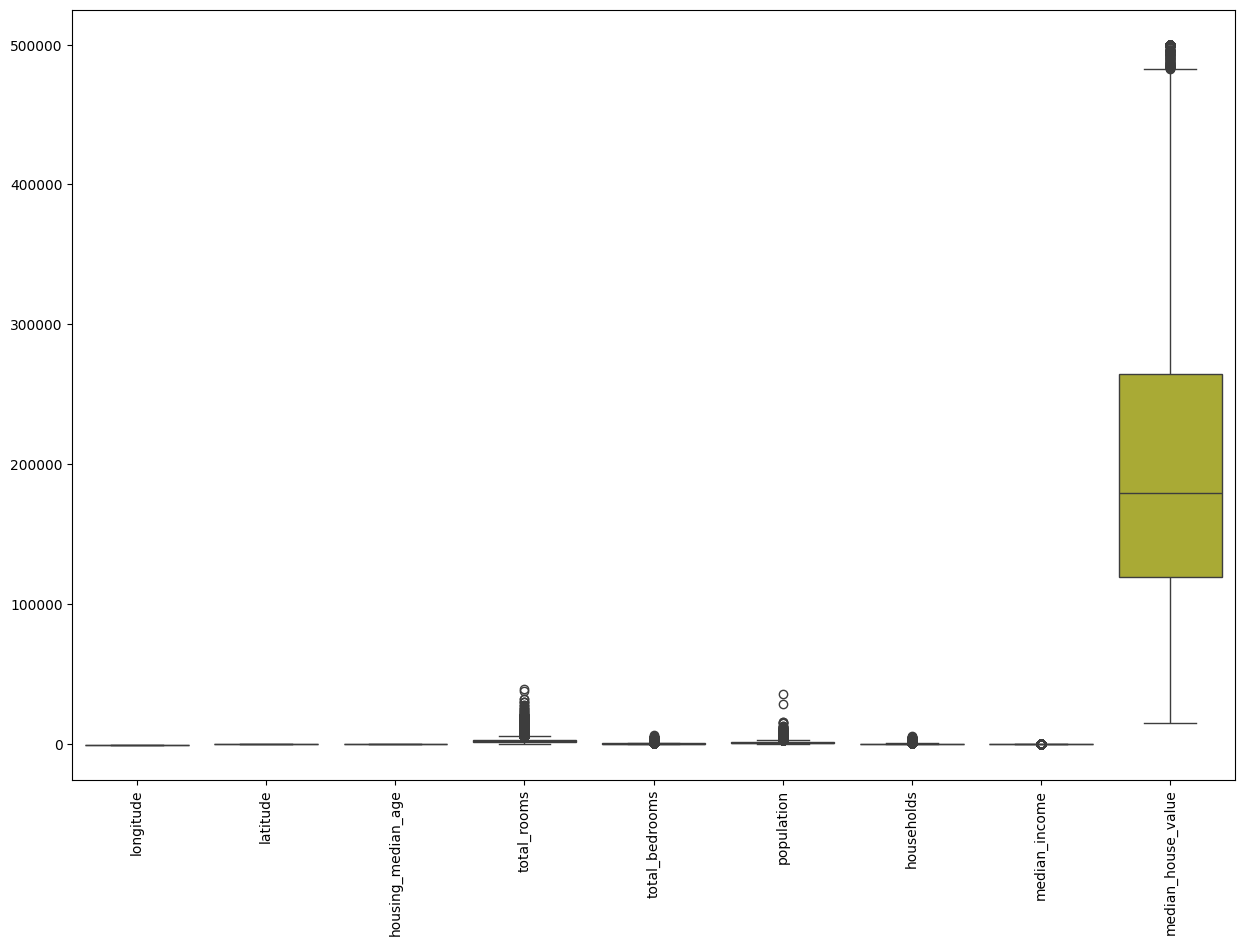

In [ ]:
# Detecting outliers using boxplots
plt.figure(figsize=(15,10))
sns.boxplot(data=housing.select_dtypes(include=[np.number]))
plt.xticks(rotation=90)
plt.show()

In [ ]:
#Identifying outliers using IQR
def detect_outliers(data, features):
    outliers = {}
    for feature in features:
      Q1 = data[feature].quantile(0.25)
      Q3 = data[feature].quantile(0.75)
      IQR = Q3 - Q1
      lower_bound = Q1 - 1.5 * IQR
      upper_bound = Q3 + 1.5 * IQR
      outliers[feature] = data[(data[feature] < lower_bound) | (data[feature] > upper_bound)][feature]
    return outliers

In [ ]:
num_features = housing.select_dtypes(include=[np.number]).columns.tolist()
outliers_detected = detect_outliers(housing, num_features)
print("Detected Outliers: ", {k: len(v) for k, v in outliers_detected.items()})

Detected Outliers:  {'longitude': 0, 'latitude': 0, 'housing_median_age': 0, 'total_rooms': 1287, 'total_bedrooms': 1271, 'population': 1196, 'households': 1220, 'median_income': 681, 'median_house_value': 1071}


In [ ]:
def cap_outliers(data, features):
    for feature in features:
        Q1 = data[feature].quantile(0.25)
        Q3 = data[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Cap the outliers
        data[feature] = np.where(data[feature] < lower_bound, lower_bound,
                                  np.where(data[feature] > upper_bound, upper_bound, data[feature]))
    return data

# Apply Outlier Capping
housing = cap_outliers(housing, num_features)

In [ ]:
housing.shape

(20640, 10)

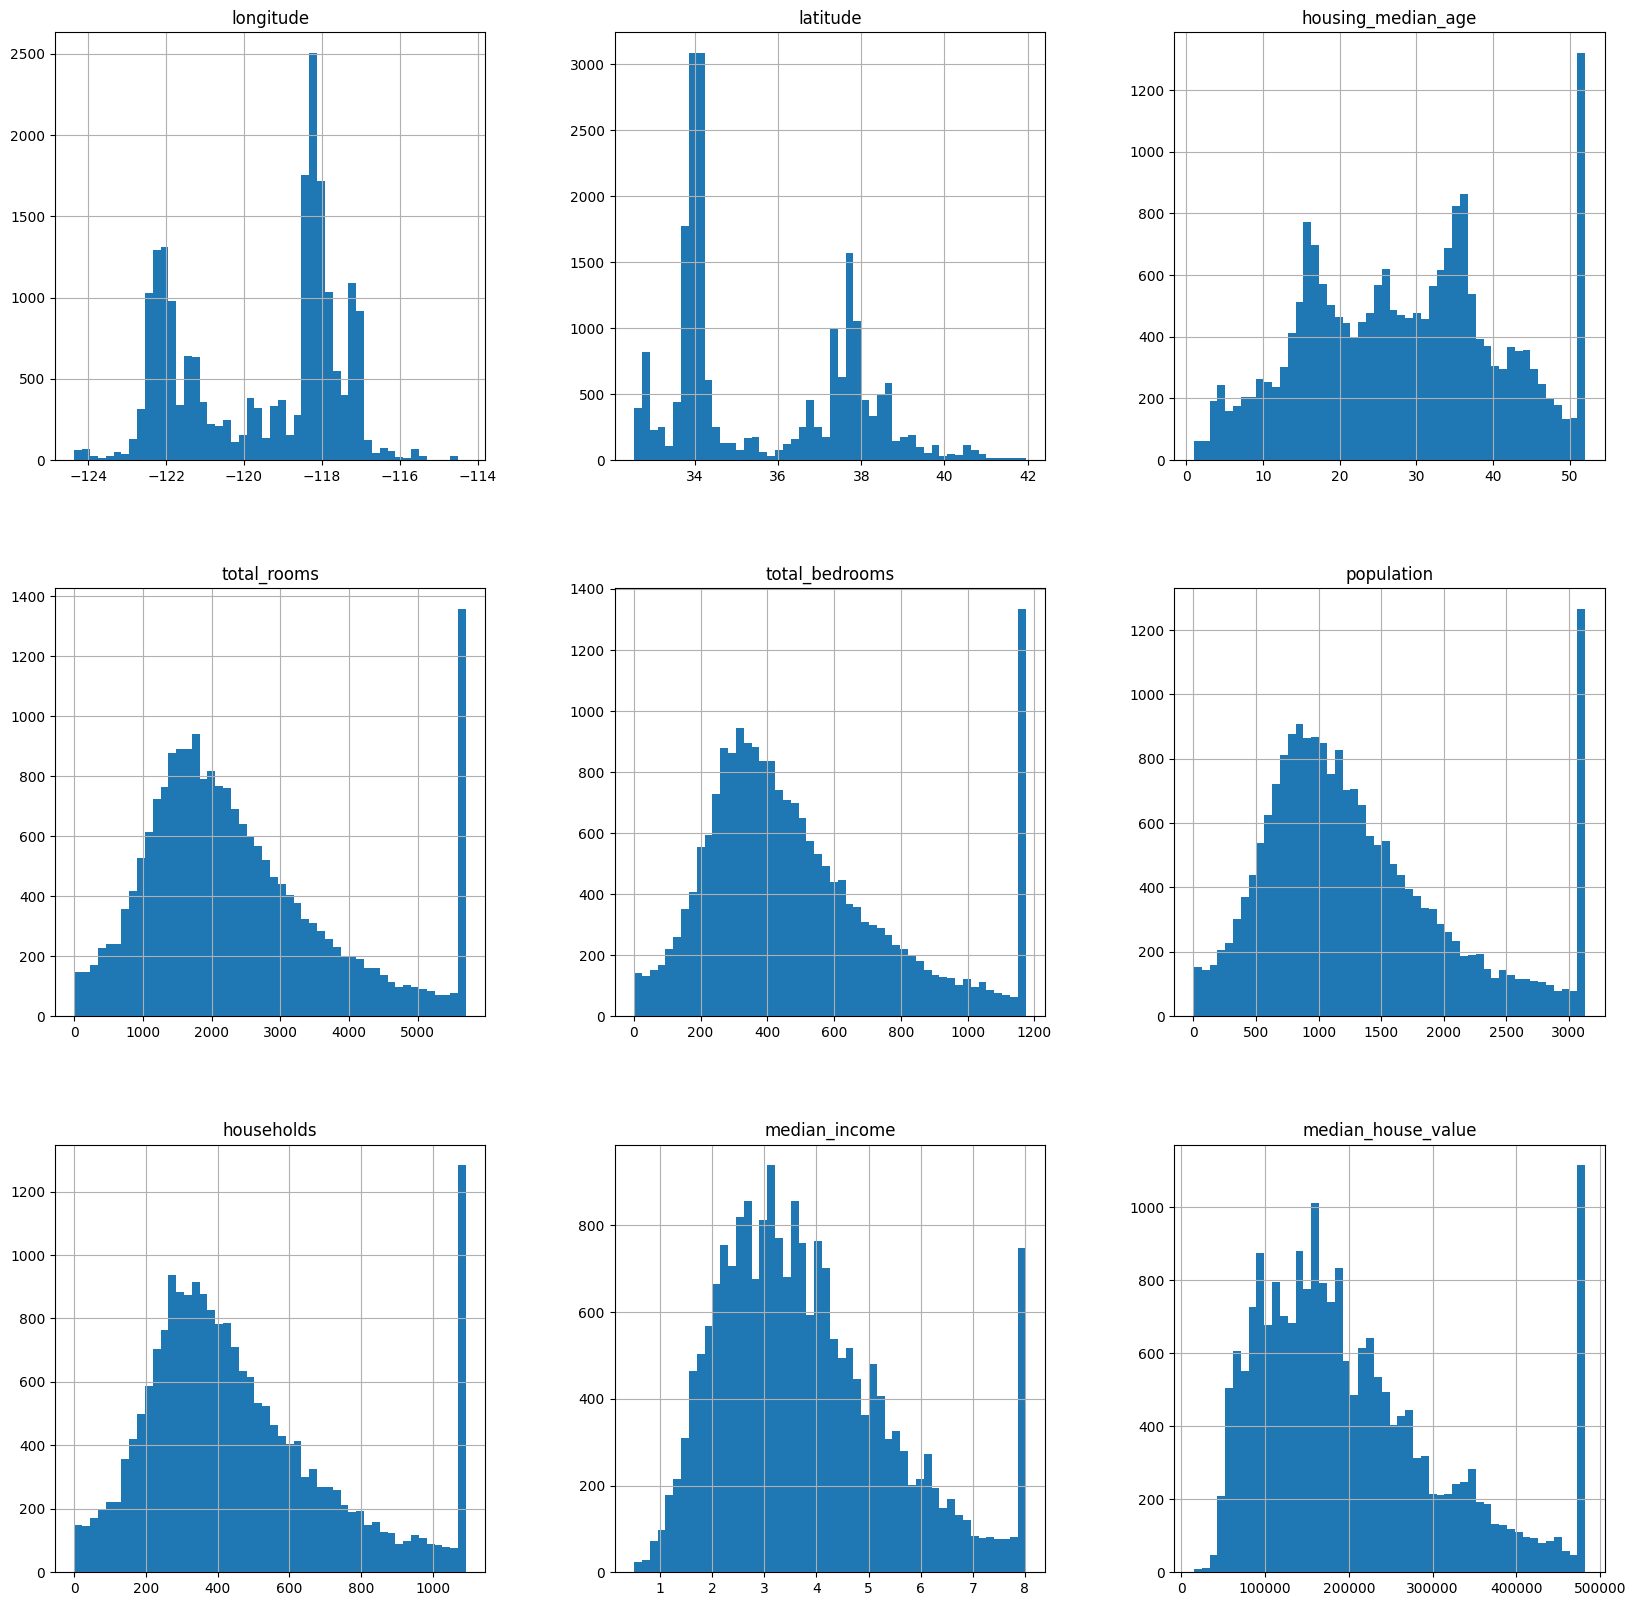

In [ ]:
# Visualizing the data distribution
housing.hist(bins=50, figsize=(20,20))
plt.show()

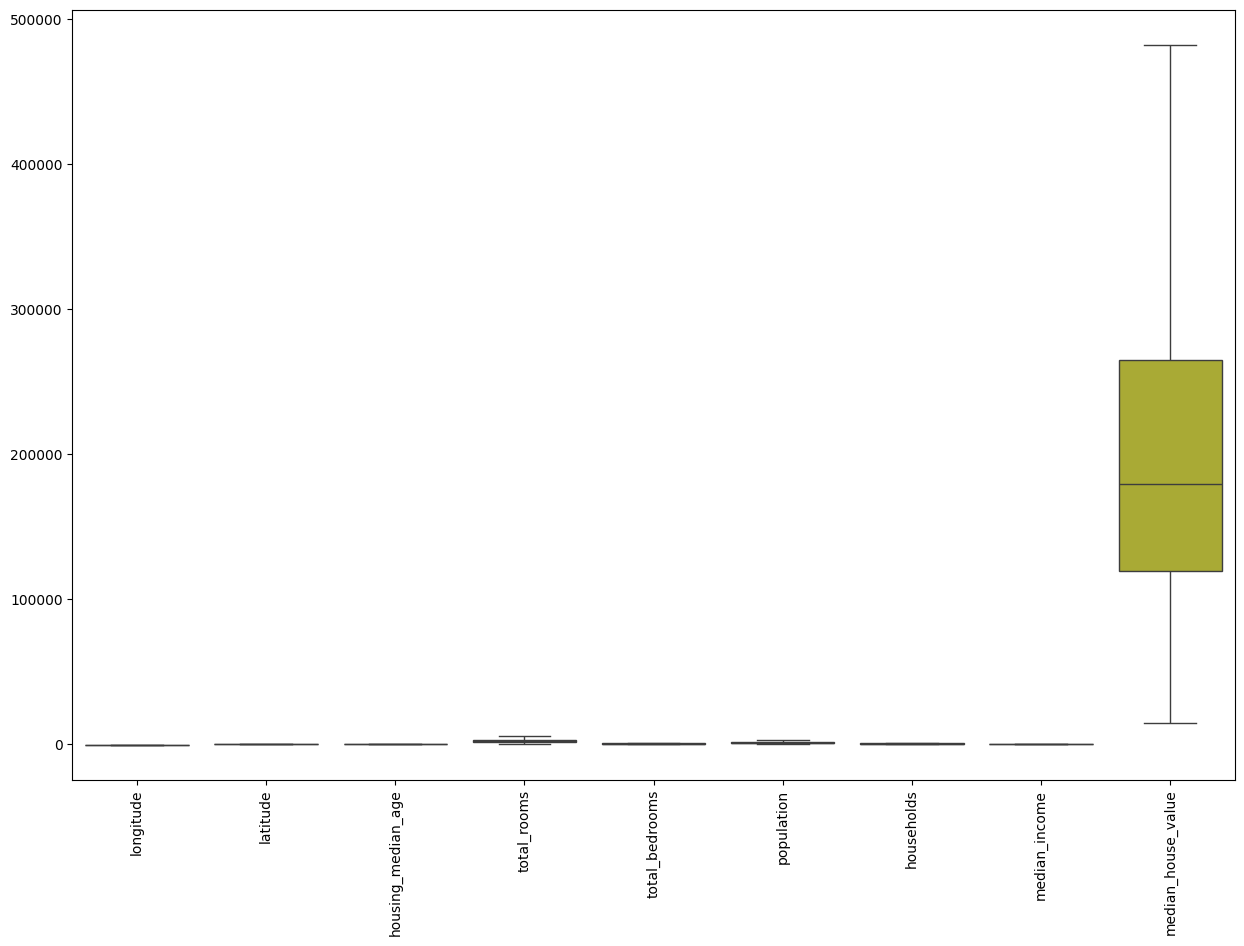

In [ ]:
# Detecting outliers using boxplots
plt.figure(figsize=(15,10))
sns.boxplot(data=housing.select_dtypes(include=[np.number]))
plt.xticks(rotation=90)
plt.show()

# Splitting the dataset

In [ ]:
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [ ]:
housing["income_cat"] = pd.cut(housing["median_income"], bins=[0., 1.5, 3.0, 4.5, 6., np.inf], labels=[1,2,3,4,5])

In [ ]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing,housing["income_cat"]):
  strain_set = housing.loc[train_index]
  stest_set = housing.loc[test_index]

In [ ]:
for temp_set in (strain_set, stest_set):
  temp_set.drop("income_cat", axis=1, inplace=True)

In [ ]:
corr_matrix = strain_set.select_dtypes(include=[np.number]).corr()
print(corr_matrix["median_house_value"].sort_values(ascending=False))

median_house_value    1.000000
median_income         0.689342
total_rooms           0.176943
housing_median_age    0.100936
households            0.085317
total_bedrooms        0.065928
population           -0.027062
longitude            -0.051122
latitude             -0.140959
Name: median_house_value, dtype: float64


In [ ]:
# Separate features and labels for training and testing
housing_train = strain_set.drop("median_house_value", axis=1)
housing_labels = strain_set["median_house_value"].copy()
housing_test = stest_set.drop("median_house_value", axis=1)
housing_test_labels = stest_set["median_house_value"].copy()

In [ ]:
num_features = housing_train.select_dtypes(include=[np.number]).columns.tolist()

cat_features = ["ocean_proximity"]

## Pipelines

In [ ]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy = "median")),
    ("std_scaler", StandardScaler())
])

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_features),
    ("cat", OneHotEncoder(), cat_features)
])


In [ ]:
housing_prepared = full_pipeline.fit_transform(housing_train)
housing_test_prepared = full_pipeline.transform(housing_test)

# Model Selection

In [ ]:
#Linear Regression Model
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)
predictions = lin_reg.predict(housing_prepared)
mse = mean_squared_error(housing_labels, predictions)
rmse = np.sqrt(mse)
print(f"Linear Regression RMSE: {rmse}")

Linear Regression RMSE: 65401.54954966422


In [ ]:
#Random Forest Model
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)
forest_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, forest_predictions)
forest_rmse = np.sqrt(forest_mse)
print(f"Forest RMSE: {forest_rmse}")

Forest RMSE: 17671.413389615103


# Evaluation

In [ ]:
final_predictions = forest_reg.predict(housing_test_prepared)
test_mse = mean_squared_error(housing_test_labels, final_predictions)
test_rmse = np.sqrt(test_mse)
print(f"Test RMSE: {test_rmse}")

Test RMSE: 48389.34403157498


# Hyperparameter Tuning

In [ ]:
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_features': ['sqrt', 'log2', None]
}
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_root_mean_squared_error')
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_features': ['sqrt', 'log2', None],
                         'n_estimators': [50, 100, 150]},
             scoring='neg_root_mean_squared_error')

In [ ]:
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Score: {-grid_search.best_score_}")

Best Parameters: {'max_features': None, 'n_estimators': 150}
Best Score: 48272.160242669976


In [ ]:
best_model = grid_search.best_estimator_
best_model.fit(housing_prepared, housing_labels)

RandomForestRegressor(max_features=None, n_estimators=150)

In [ ]:
final_predictions = best_model.predict(housing_test_prepared)
final_mse = mean_squared_error(housing_test_labels, final_predictions)
final_rmse = np.sqrt(final_mse)
print(f"Final Test RMSE: {final_rmse}")

Final Test RMSE: 48346.12655072941


In [ ]:
import joblib

joblib.dump(best_model, 'best_housing_model.pkl')
print("Model saved!")

Model saved!


In [ ]:
model = joblib.load('best_housing_model.pkl')

In [ ]:
model.fit(housing_prepared, housing_labels)
model_mse = mean_squared_error(housing_test_labels, model.predict(housing_test_prepared))
model_rmse = np.sqrt(model_mse)
print(f"Model RMSE: {model_rmse}")

Model RMSE: 48488.66105684951


In [ ]:
np.__version__

'2.0.2'

In [ ]:
pd.__version__

'2.2.2'

In [ ]:
import sklearn
sklearn.__version__

'1.6.1'

In [ ]:
!pip freeze

absl-py==1.4.0
accelerate==1.5.2
aiohappyeyeballs==2.6.1
aiohttp==3.11.14
aiosignal==1.3.2
alabaster==1.0.0
albucore==0.0.23
albumentations==2.0.5
ale-py==0.10.2
altair==5.5.0
annotated-types==0.7.0
anyio==4.9.0
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
array_record==0.7.1
arviz==0.21.0
astropy==7.0.1
astropy-iers-data==0.2025.3.17.0.34.53
astunparse==1.6.3
atpublic==5.1
attrs==25.3.0
audioread==3.0.1
autograd==1.7.0
babel==2.17.0
backcall==0.2.0
beautifulsoup4==4.13.3
betterproto==2.0.0b6
bigframes==1.40.0
bigquery-magics==0.8.0
bleach==6.2.0
blinker==1.9.0
blis==1.2.0
blosc2==3.2.0
bokeh==3.6.3
Bottleneck==1.4.2
bqplot==0.12.44
branca==0.8.1
CacheControl==0.14.2
cachetools==5.5.2
catalogue==2.0.10
certifi==2025.1.31
cffi==1.17.1
chardet==5.2.0
charset-normalizer==3.4.1
chex==0.1.89
clarabel==0.10.0
click==8.1.8
cloudpathlib==0.21.0
cloudpickle==3.1.1
cmake==3.31.6
cmdstanpy==1.2.5
colorcet==3.1.0
colorlover==0.3.0
colour==0.1.5
community==1.0.0b1
confection==0.1.5
cons==0.4.6


In [ ]:
pip --version

pip 24.1.2 from /usr/local/lib/python3.11/dist-packages/pip (python 3.11)


In [ ]:
joblib.__version__

'1.4.2'

In [ ]:
python3 --version


NameError: name 'python3' is not defined

In [ ]:
!python3 --version

Python 3.11.11
